## Imports 


In [33]:
# data 
import mysql.connector
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# modeling 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# parameter tuning
from sklearn.model_selection import GridSearchCV

# performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from mlxtend.plotting import plot_confusion_matrix # replacement to sklearn cm 
from mlxtend.evaluate import confusion_matrix
import matplotlib.pyplot as plt


## Loading data from MySQL

The etl that uses kaggle api is available in the Loan_Data_ETL_Approval_Prediction repo. 

In [34]:
try:
    mydb = mysql.connector.connect(
        host = "YOURHOST",
        user = "YOURROOT",
        password = "YOURPASSWORD",
        database = "loan_db", 
    )
    query = "Select * From loan_approval;"
    df = pd.read_sql(query,mydb)
    mydb.close() #close the connection

except:
    print('error')

## Dealing with n/a values 
    
Replaced missing values with the mean for numeric features and most common for categorical 

In [2]:
# drop not needed columns 
df = df.drop(columns=['Loan_ID'])

# dealing with na values 

print('Number of missing values by Columns')
print(df.isnull().sum())

df['Gender'].fillna(df['Gender'].value_counts().idxmax(), inplace=True)
df['Married'].fillna(df['Married'].value_counts().idxmax(), inplace=True)
df['Dependents'].fillna(df['Dependents'].value_counts().idxmax(), inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].value_counts().idxmax(), inplace=True)
df["LoanAmount"].fillna(df["LoanAmount"].mean(skipna=True), inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].value_counts().idxmax(), inplace=True)
df['Credit_History'].fillna(df['Credit_History'].value_counts().idxmax(), inplace=True)

df.isnull().sum()

Number of missing values by Columns
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

## Encoding categorical features 

In [3]:
df = pd.get_dummies(df)
df.drop(['Loan_Status_N'], axis = 1, inplace = True)
df.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,...,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y
0,5849,0.0,146.412162,360.0,1.0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,1,1
1,4583,1508.0,128.000000,360.0,1.0,0,1,0,1,0,...,0,0,1,0,1,0,1,0,0,0
2,3000,0.0,66.000000,360.0,1.0,0,1,0,1,1,...,0,0,1,0,0,1,0,0,1,1
3,2583,2358.0,120.000000,360.0,1.0,0,1,0,1,1,...,0,0,0,1,1,0,0,0,1,1
4,6000,0.0,141.000000,360.0,1.0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,1,1


## Scaling numeircal features using MinMaxScaler 

Feature scaling is important when dealing with Gradient Descent Based algorithms (Linear and Logistic Regression, Neural Network) and Distance-based algorithms (KNN, K-means, SVM) as these are very sensitive to the range of the data points. This step is not mandatory when dealing with Tree-based algorithms.
 
[towardsdatascience.com/feature-scaling](https://towardsdatascience.com/feature-scaling-effectively-choose-input-variables-based-on-distributions-3032207c921f)


In [4]:
num_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

df[num_columns] = MinMaxScaler().fit_transform(df[num_columns])

df.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,...,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y
0,0.070489,0.000000,0.198860,0.74359,1.0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,1,1
1,0.054830,0.036192,0.172214,0.74359,1.0,0,1,0,1,0,...,0,0,1,0,1,0,1,0,0,0
2,0.035250,0.000000,0.082489,0.74359,1.0,0,1,0,1,1,...,0,0,1,0,0,1,0,0,1,1
3,0.030093,0.056592,0.160637,0.74359,1.0,0,1,0,1,1,...,0,0,0,1,1,0,0,0,1,1
4,0.072356,0.000000,0.191027,0.74359,1.0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,1,1


## Spliting our data 

Starting with a 70 30 training and testing set for model building

In [5]:
x = df.drop(columns='Loan_Status_Y')
y = df['Loan_Status_Y']


x_train,x_test,y_train,y_test = train_test_split(x, y, train_size=0.7, random_state = 42)

## Model Buidling, Machine Learning Classification

Logistic Regression, K-Nearest Neighbors, Gradient Boosting Classifier, and Random Forest will be used. Performance will be mesaured using F1, Accuary, Percesion, and ROC-AUC. Followed by parameter tuning. 

In [6]:
def performance_eval(model_name,y_test,y_pred,y_scores_proba):
    
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    print(f'{model_name} f1_score: {f1}') 
    print(f'{model_name} accuracy_score: {accuracy}')  
    print(f'{model_name} precision_score: {precision}') 
    print(f'{model_name} recall_score: {recall}')  
    
    cm = confusion_matrix(y_target = y_test, y_predicted = y_pred)
    ax = plt.subplot(1, 3, 1)
    plot_confusion_matrix(conf_mat = cm, cmap = plt.cm.Greens, axis=ax)
    fpr, tpr, threshold = roc_curve(y_test, y_scores_proba[:, 1])
    roc_auc = auc(fpr, tpr)

    
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc = 'lower right')
    plt.subplot(1, 2, 2)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(f'ROC Curve of {model_name}')
    plt.rcParams["figure.figsize"] = (20,5)
    plt.show()

In [7]:
# log reg fit and predict

log = LogisticRegression()

log.fit(x_train,y_train)

y_pred_log = log.predict(x_test)

y_log_proba = log.predict_proba(x_test)

log_reg f1_score: 0.8550724637681159
log_reg accuracy_score: 0.7837837837837838
log_reg precision_score: 0.7564102564102564
log_reg recall_score: 0.9833333333333333


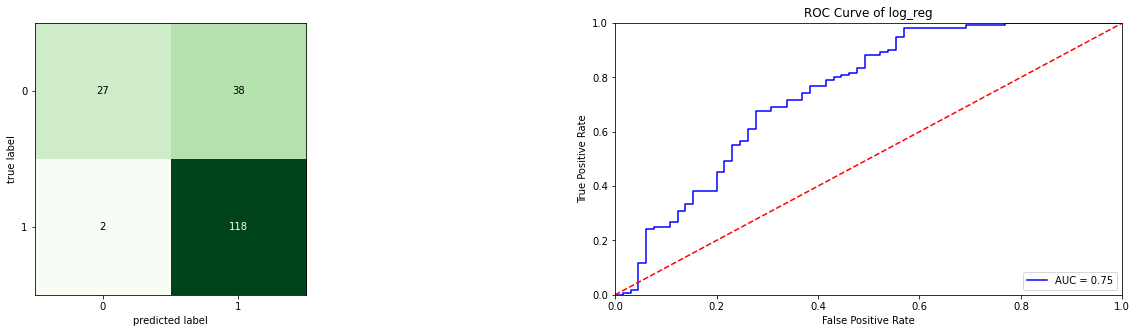

In [32]:
# log reg evaluation

performance_eval('log_reg',y_test,y_pred_log,y_log_proba)

In [9]:
# knn fit and predict

knn = KNeighborsClassifier()

knn.fit(x_train,y_train)

y_pred_knn = knn.predict(x_test)

y_knn_proba = knn.predict_proba(x_test)

knn f1_score: 0.7753623188405797
knn accuracy_score: 0.6648648648648648
knn precision_score: 0.6858974358974359
knn recall_score: 0.8916666666666667


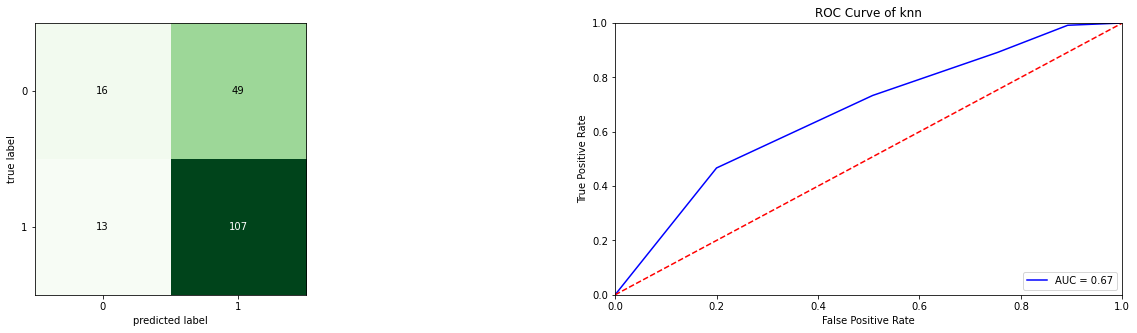

In [10]:
# knn evaluation

performance_eval('knn',y_test,y_pred_knn,y_knn_proba)

In [11]:
# rfc fit and predict

rfc = RandomForestClassifier(random_state = 99999)

rfc.fit(x_train,y_train)

y_pred_rfc = rfc.predict(x_test)

y_rfc_proba = rfc.predict_proba(x_test)

rfc f1_score: 0.8401486988847583
rfc accuracy_score: 0.7675675675675676
rfc precision_score: 0.7583892617449665
rfc recall_score: 0.9416666666666667


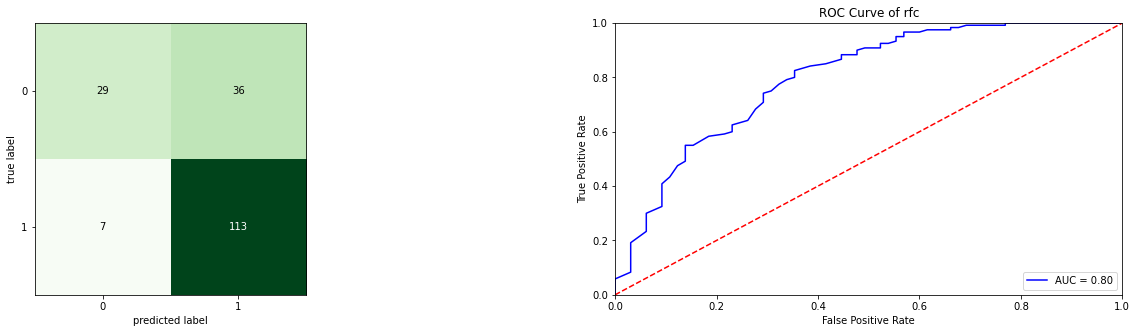

In [12]:
# rfc evaluation

performance_eval('rfc',y_test,y_pred_rfc,y_rfc_proba)

In [13]:
# gbc fit and predict

gbc = GradientBoostingClassifier()

gbc.fit(x_train,y_train)

y_pred_gbc = gbc.predict(x_test)

y_gbc_proba = gbc.predict_proba(x_test)

gbc f1_score: 0.8278388278388278
gbc accuracy_score: 0.745945945945946
gbc precision_score: 0.738562091503268
gbc recall_score: 0.9416666666666667


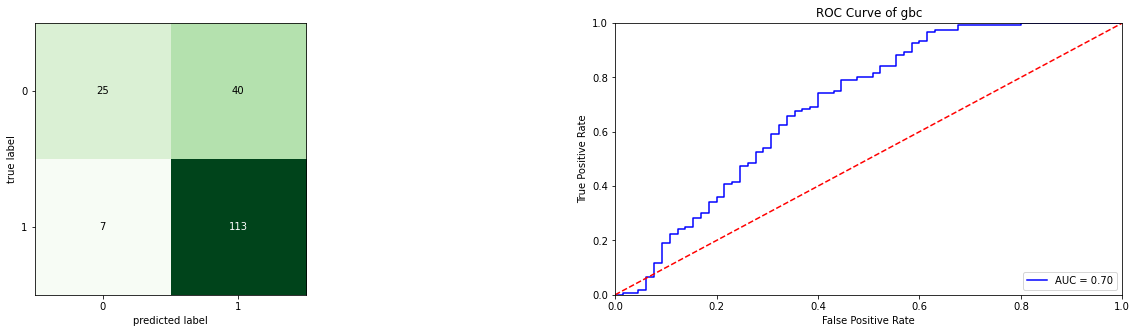

In [14]:
# gbc evaluation

performance_eval('gbc',y_test,y_pred_gbc,y_gbc_proba)

## Hyperparameter Tunning 

In [15]:
def paramter_tunning(xtrain,ytrain,xtest,ytest,type_model,name,parameters,cv_num,scoring_metrics):
    
    model = type_model
    
    gs = GridSearchCV(estimator = type_model
                    ,param_grid = parameters
                    ,scoring = scoring_metrics
                    ,cv = cv_num
                     ) 
    gs.fit(xtrain,ytrain)
    
    best_model = gs.best_estimator_

    best_model.fit(xtrain,ytrain)

    best_y_pred = best_model.predict(xtest)
    
    best_y_proba = best_model.predict_proba(x_test)

    # best model evaluation
    
    performance_eval(name,ytest,best_y_pred,best_y_proba) 
    
    return gs.best_estimator_ 
                            
    
    

knn f1_score: 0.8239700374531835
knn accuracy_score: 0.745945945945946
knn precision_score: 0.7482993197278912
knn recall_score: 0.9166666666666666


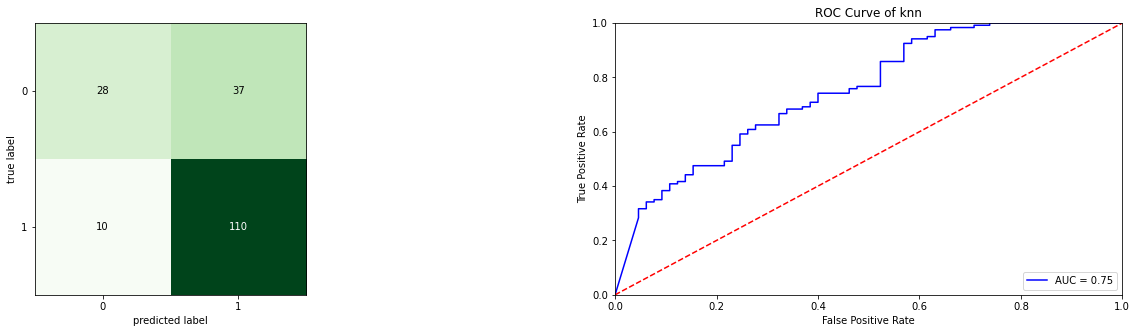

KNeighborsClassifier(leaf_size=10, n_neighbors=10, weights='distance')

In [16]:
# knn

parameters_KNN = {
    'n_neighbors': (1,5,10,15),
    'leaf_size': (10,20,30,40),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev')
    }

paramter_tunning(x_train,y_train,x_test,y_test,knn,'knn', parameters_KNN, 5, 'accuracy')

rfc f1_score: 0.830188679245283
rfc accuracy_score: 0.7567567567567568
rfc precision_score: 0.7586206896551724
rfc recall_score: 0.9166666666666666


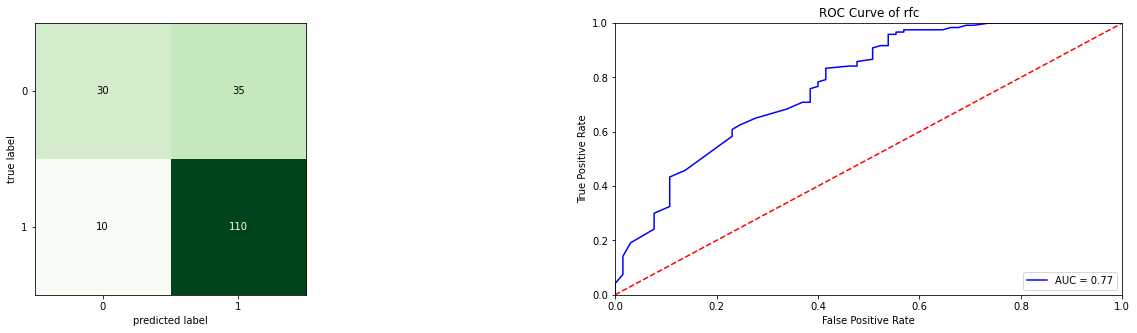

RandomForestClassifier(max_features='sqrt', n_estimators=75, random_state=1)

In [28]:
#rfc

parameters_rfc = { 
    'n_estimators': [20, 50, 75, 200]
    , 'max_features': ['sqrt', 'log2']
    , 'criterion' :['gini', 'entropy']
    }


paramter_tunning(x_train,y_train,x_test,y_test,rfc,'rfc', parameters_rfc, 5, 'accuracy')

gbc f1_score: 0.8458781362007167
gbc accuracy_score: 0.7675675675675676
gbc precision_score: 0.7421383647798742
gbc recall_score: 0.9833333333333333


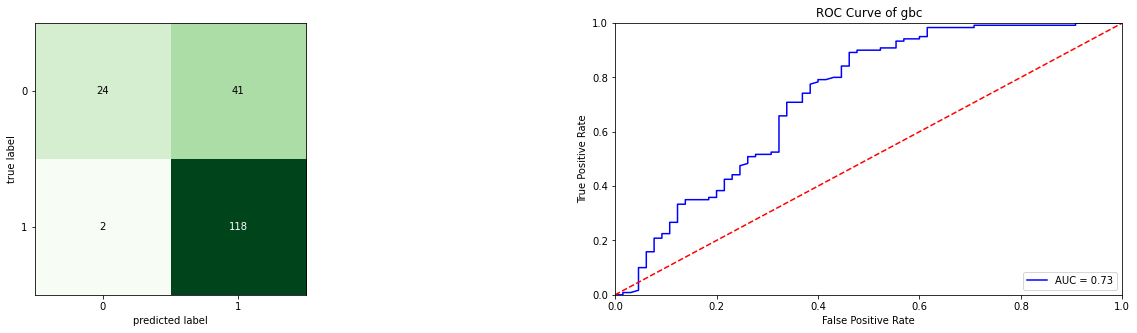

GradientBoostingClassifier(learning_rate=0.09, loss='exponential',
                           n_estimators=50)

In [18]:
# gbc 

parameters_gbc = {
    "n_estimators":[25,50,75,100,125]
    , "learning_rate": [0.01, 0.025, 0.03,0.09]
    , "loss":["deviance",'exponential']
#     , 'max_depth': [1,2,3,4]
    }


paramter_tunning(x_train,y_train,x_test,y_test,gbc,'gbc', parameters_gbc, 5, 'accuracy')

## Feature Importance 

Now that we know the best model is a Random Forest Classifier, we can determine which features the model thought were the most important in making a decision. Using .best_estimator_.feature_importances_

In [29]:
def feature_importance(df, model):
    feat = pd.DataFrame(columns=[ 'feature', 'importance'])
    feat["feature"] = df.columns
    feat["importance"] = model.best_estimator_.feature_importances_
    
    return feat.sort_values (by="importance", ascending=False)

In [30]:
rfc_fi = RandomForestClassifier()

parameters_rfc_fi = { 
    'n_estimators': [20, 50, 75, 200]
    , 'max_features': ['sqrt', 'log2']
    , 'criterion' :['gini', 'entropy']
    }

rfc_gs = GridSearchCV(estimator = rfc
                ,param_grid = parameters_rfc
                ,scoring = 'accuracy'
                ,cv = 5
                 ) 
rfc_gs.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=99999),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [20, 50, 75, 200],
                         'random_state': [None, 1, 5, 9]},
             scoring='accuracy')

Text(0, 0.5, 'Feature')

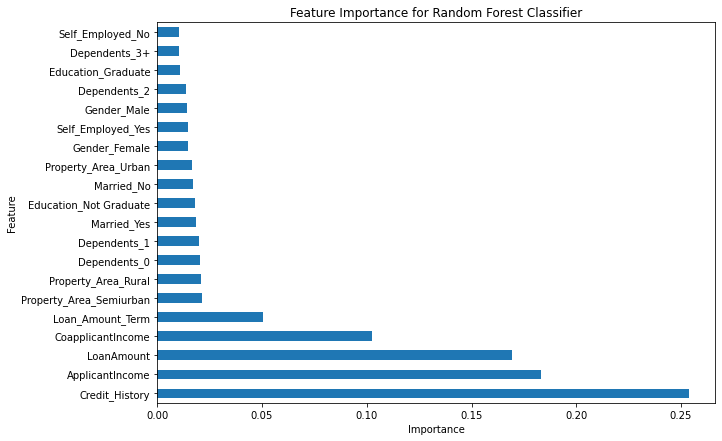

In [31]:
ax = feature_importance(x_train,rfc_gs).plot('feature','importance','barh' 
                             , title = f'Feature Importance for Random Forest Classifier'
                             , figsize=(10,7)
                             , legend = False)
ax.set_xlabel("Importance")
ax.set_ylabel("Feature")